In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
sys.path.append('../src/')

In [3]:
from preprocess import *
from dp import *
from ClusterEnsembles import *

In [4]:
# set plotting params
import matplotlib as mpl
import plots
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.reload_library()
rcparams = plots.stdrcparams()
mpl.rcParams.update(rcparams)

In [5]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import adjusted_rand_score
from sklearn.mixture import GaussianMixture

# syn representative

In [6]:
%%time
np.random.seed(9)

n_smp = 20
n_feats = [4,10]
n_classes = [2,4,8]
noise_ratios = [0.1, 0.5]
rs = np.random.randint(100, size=n_smp)

X = pd.DataFrame()
centers_list = []
cluster_std_list = []
scalers_list = []

for i in range(n_smp):
    for n_feat in n_feats:
        for n_class in n_classes:
            for noise_ratio in noise_ratios:
                cluster_sizes = np.random.choice(range(50, 500), size=n_class, replace=False)
                cluster_std = np.random.uniform(1, 3, )
                xi,yi,ci = make_blobs(n_samples=cluster_sizes, n_features=n_feat, cluster_std=cluster_std, random_state=rs[i], return_centers=True)
                scaler = MinMaxScaler()
                xi = scaler.fit_transform(xi)
                ui = np.random.uniform(low=0, high=1, size=(int(sum(cluster_sizes)*noise_ratio), n_feat))
                xi = np.concatenate((xi,ui))
                yi = np.concatenate((yi, np.repeat(-1, int(sum(cluster_sizes)*noise_ratio))))
                xi = pd.DataFrame(xi, columns=[f'x{j}' for j in np.arange(1,n_feat+1)])
                xi = xi.assign(smp=i)
                xi = xi.assign(y_true=yi)
                xi = xi.assign(n_class=n_class)
                xi = xi.assign(n_feat=n_feat)
                xi = xi.assign(noise_ratio=noise_ratio)
                xi = xi.assign(cluster_std=cluster_std)
                X = pd.concat([X, xi], ignore_index=True)

                if n_feat == 4 and n_class == 4 and noise_ratio == 0.5 and i == 19:
                    centers_list.append(ci)
                    cluster_std_list.append(cluster_std)
                    scalers_list.append(scaler)
                # break

CPU times: user 588 ms, sys: 388 ms, total: 976 ms
Wall time: 1.04 s


In [7]:
# X.to_csv('../data/calculated/dp/synthetic/simulated_data.csv', index=False)
X = pd.read_csv('../data/calculated/dp/synthetic/simulated_data.csv')

In [8]:
tmp = X[(X['n_class']==4) & (X['n_feat']==4) & (X['noise_ratio']==0.5) & (X['smp']==19)]

<Axes: xlabel='x3', ylabel='x4'>

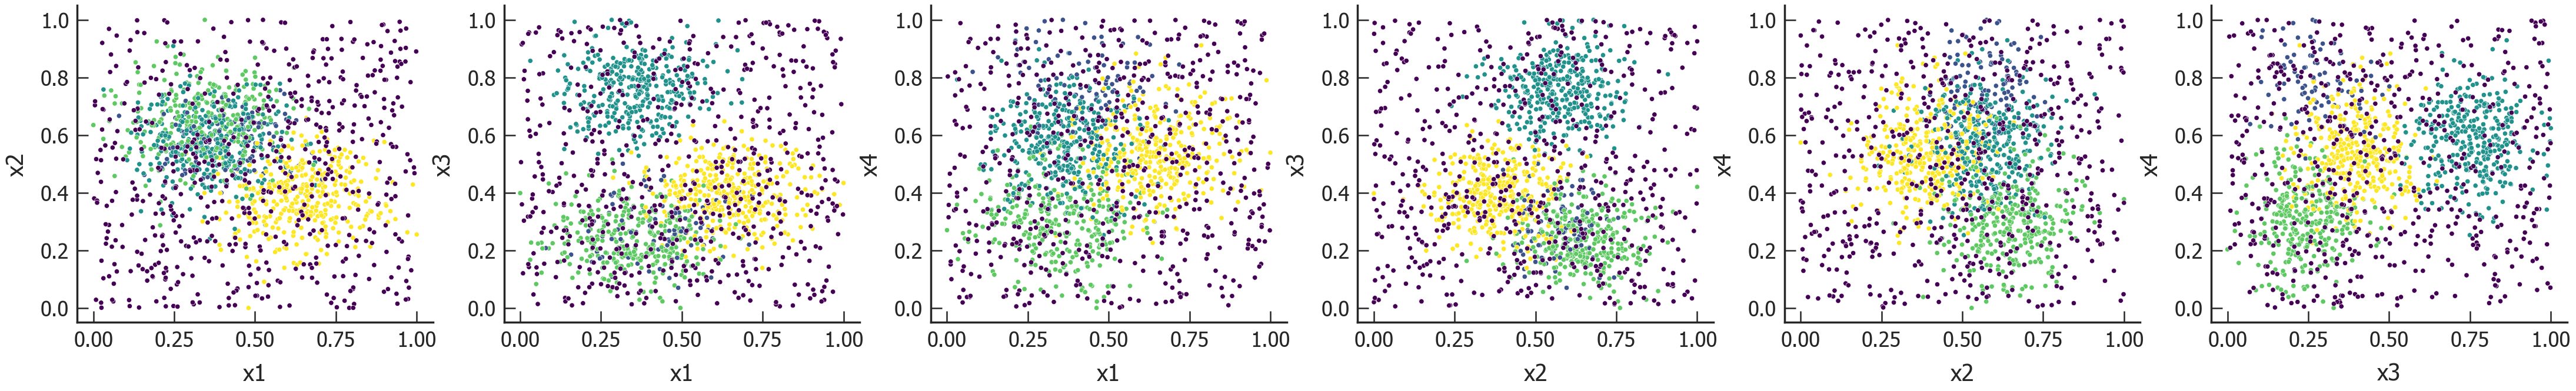

In [9]:
fig, axs = plt.subplots(1,6, figsize=plots.stdfigsize(1,6))

sns.scatterplot(data=tmp, x='x1', y='x2', hue='y_true', ax=axs[0], legend=False, palette='viridis')
sns.scatterplot(data=tmp, x='x1', y='x3', hue='y_true', ax=axs[1], legend=False, palette='viridis')
sns.scatterplot(data=tmp, x='x1', y='x4', hue='y_true', ax=axs[2], legend=False, palette='viridis')
sns.scatterplot(data=tmp, x='x2', y='x3', hue='y_true', ax=axs[3], legend=False, palette='viridis')
sns.scatterplot(data=tmp, x='x2', y='x4', hue='y_true', ax=axs[4], legend=False, palette='viridis')
sns.scatterplot(data=tmp, x='x3', y='x4', hue='y_true', ax=axs[5], legend=False, palette='viridis')

In [10]:
specified_centers = centers_list[-1]
specified_cluster_std = cluster_std_list[-1]
specified_scaler = scalers_list[-1]

Text(0, 0.5, 'Dimension 2')

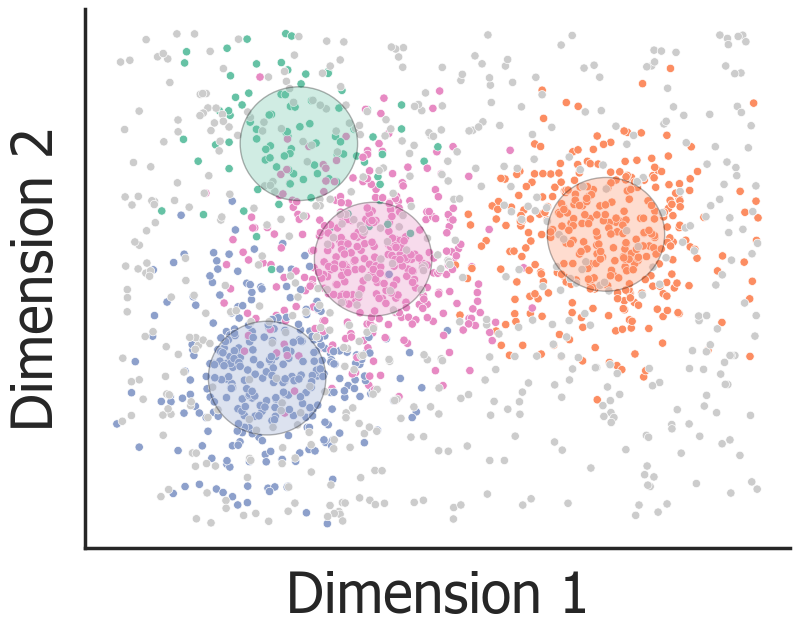

In [11]:
fig, ax = plt.subplots(1,1, figsize=plots.stdfigsize(1,1))
sns.scatterplot(data=tmp, x='x3', y='x4', hue='y_true', legend=False, palette=['0.8','#66c2a5','#fc8d62','#8da0cb','#e78ac3'], ax=ax)

for idx, center in enumerate(specified_centers):
    center_transformed = specified_scaler.transform(center.reshape(1, -1)).flatten()
    std_transformed = np.full((1, 4), specified_cluster_std).flatten()/specified_scaler.data_range_
    ell = mpl.patches.Ellipse(center_transformed[2:4], width=std_transformed[2]*2, height=std_transformed[3]*2, edgecolor='black', facecolor=['#66c2a5','#fc8d62','#8da0cb','#e78ac3'][idx])
    ell.set_alpha(.3)
    ax.add_artist(ell)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Dimension 1', fontsize=40)
ax.set_ylabel('Dimension 2', fontsize=40)

In [12]:
dfs = []
for file in os.listdir('../data/calculated/dp/synthetic/'):
    if file.endswith('.csv') and file.startswith('smp'):
        patterns = file.rstrip('.csv').split('_') 
        smp = int(patterns[0].strip('smp'))
        n_feat = int(patterns[1].strip('feat'))
        n_class = int(patterns[2].strip('class'))
        noise_ratio = float(patterns[3].strip('noise'))
        if len(patterns) == 5:
            boot = int(patterns[4].strip('boot'))
        else:
            boot = 'all'
        df = pd.read_csv(f'../data/calculated/dp/synthetic/{file}')
        df = df.assign(smp=smp)
        df = df.assign(n_feat=n_feat)
        df = df.assign(n_class=n_class)
        df = df.assign(noise_ratio=noise_ratio)
        df = df.assign(boot=boot)
        dfs.append(df)
dps = pd.concat(dfs, ignore_index=True)


In [14]:
# dfs = []
# grouped = dps.groupby(['smp', 'n_feat', 'n_class', 'noise_ratio'])
# for name, group in grouped:
#     n_feat = name[1]
#     for n_cmp in np.arange(2,15):
#         cc = group.sort_values('rd', ascending=False).iloc[:(n_cmp*101),:][[f'x{ff}' for ff in np.arange(1,n_feat+1)]].drop_duplicates()
#         kms = [KMeans(n_clusters=nn, random_state=0, n_init=5).fit(cc.values) for nn in np.arange(2,min(15, len(cc)))]
#         sls = [silhouette_score(cc, km.labels_) for km in kms]
#         df = pd.DataFrame({
#             'smp': name[0],
#             'n_feat': n_feat,
#             'n_class': name[2],
#             'noise_ratio': name[3],
#             'n_cmp_assume': n_cmp,
#             'n_cmp': np.arange(2, min(15, len(cc))),
#             'sl': sls
#         })
#         dfs.append(df)
#     # print(name)

# sls = pd.concat(dfs, ignore_index=True)

In [15]:
# sls.to_csv('../data/calculated/dp/synthetic/dps_silhouette_scores.csv', index=False)
sls = pd.read_csv('../data/calculated/dp/synthetic/dps_silhouette_scores.csv')

In [16]:
tmp = tmp.assign(
    rho = dps.loc[(dps['n_class']==4) & (dps['n_feat']==4) & (dps['noise_ratio']==0.5) & (dps['smp']==19) & (dps['boot']=='all'), 'rho'].values, 
    delta = dps.loc[(dps['n_class']==4) & (dps['n_feat']==4) & (dps['noise_ratio']==0.5) & (dps['smp']==19) & (dps['boot']=='all'), 'delta'].values, 
    rd = dps.loc[(dps['n_class']==4) & (dps['n_feat']==4) & (dps['noise_ratio']==0.5) & (dps['smp']==19) & (dps['boot']=='all'), 'rd'].values,
)


Text(0, 0.5, 'Inter-peak distance')

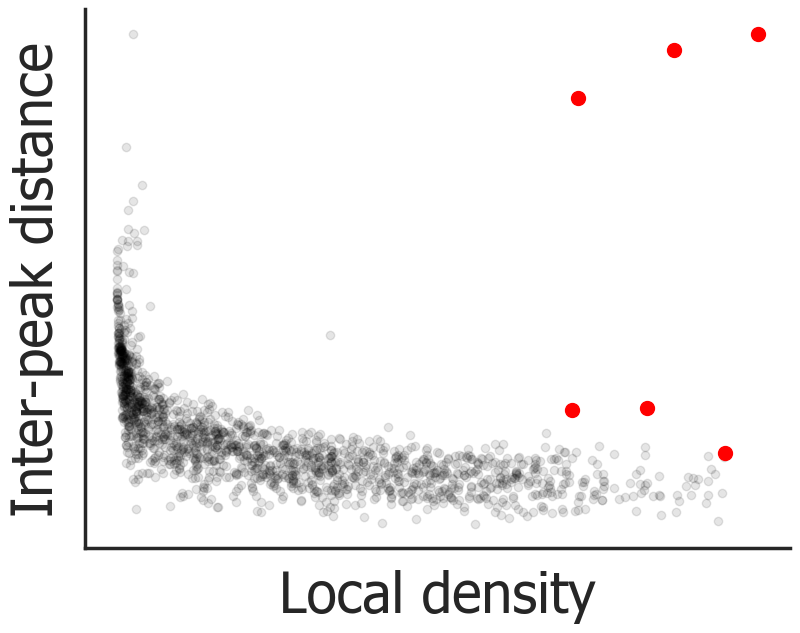

In [17]:
fig, ax = plt.subplots(1, 1, figsize=plots.stdfigsize(1,1))
ax.scatter(tmp.rho, tmp.delta, color='black', alpha=.1)
ax.scatter(tmp.sort_values('rd', ascending=False).rho[:6], tmp.sort_values('rd', ascending=False).delta[:6], s=100, color='red')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Local density', fontsize=40)
ax.set_ylabel('Inter-peak distance', fontsize=40)

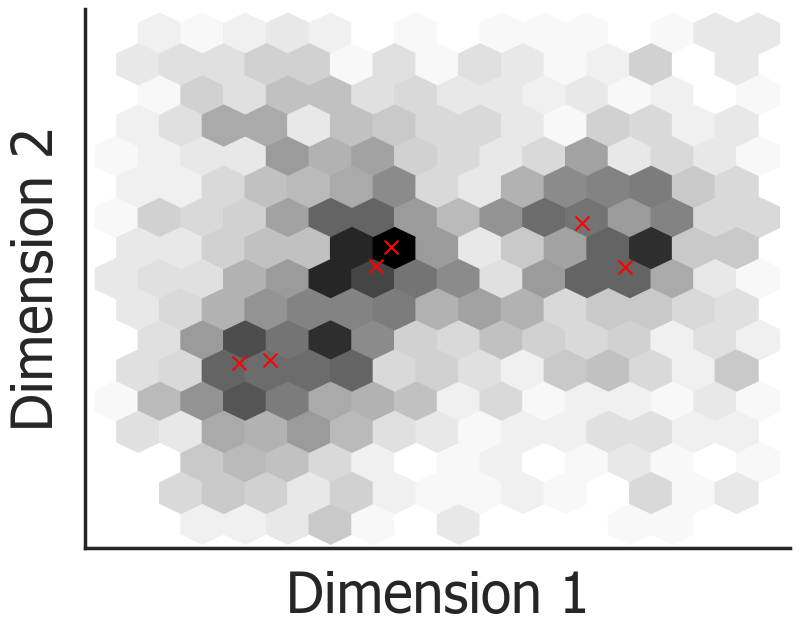

In [18]:
fig, ax = plt.subplots(1, 1, figsize=plots.stdfigsize(1,1))
ax.hexbin(tmp.loc[:,'x3'], tmp.loc[:,'x4'], cmap='gray_r', zorder=1, gridsize=15)
ax.set_xlabel('Dimension 1', fontsize=40)
ax.set_ylabel('Dimension 2', fontsize=40)
ax.set_xticks([])
ax.set_yticks([])
ax.scatter(tmp.sort_values('rd', ascending=False).x3[:6],tmp.sort_values('rd', ascending=False).x4[:6], marker='x',color="red", zorder=2, s=100)

Text(0.02, 0.5, 'Silhouette score')

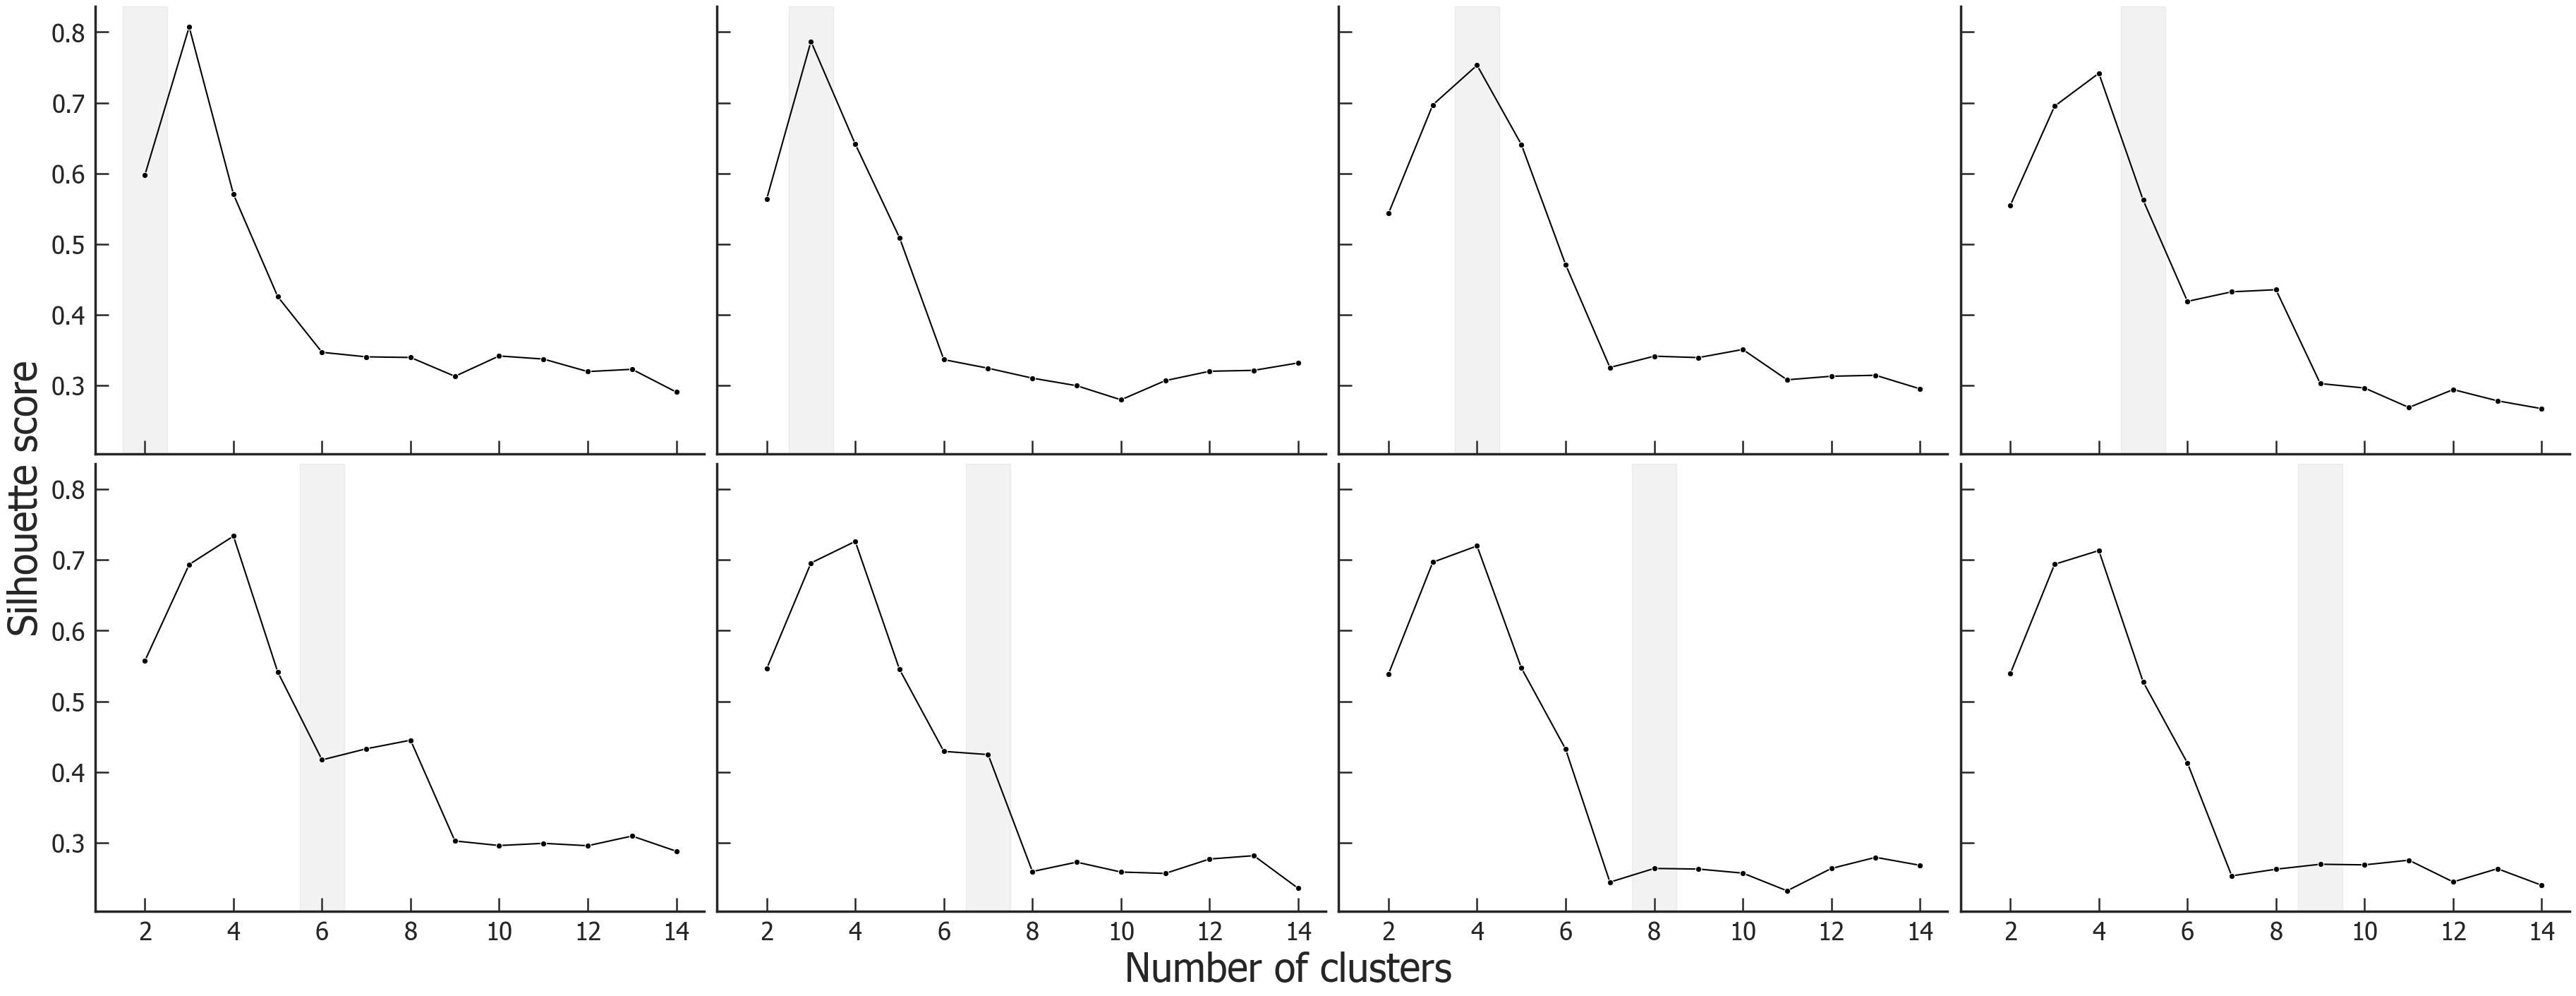

In [19]:
grps = sls[(sls['n_class']==4) & (sls['n_feat']==4) & (sls['noise_ratio']==0.5) & (sls['smp']==19)].groupby('n_cmp_assume')

nc = 4
nr = 2
fig, axs = plt.subplots(nr, nc, figsize=plots.stdfigsize(nx=nc, ny=nr), constrained_layout=True, sharex=True, sharey=True)
for n_cmp_assume, grp in grps:
    if n_cmp_assume >= 10:
        break
    ax = axs.flatten()[n_cmp_assume-2]

    sns.lineplot(data=grp, x='n_cmp', y = 'sl', ax=ax, color='black', marker='o')
    ax.axvspan(n_cmp_assume-0.5, n_cmp_assume+0.5, color='gray', alpha=0.1)
    ax.set_xlabel('')
    ax.set_ylabel('')
fig.supxlabel('Number of clusters', ha='center', fontsize=40)
fig.supylabel('Silhouette score', va='center', fontsize=40)

In [22]:
n_feat = 4
cc = dps[(dps['n_class']==4) & (dps['n_feat']==4) & (dps['noise_ratio']==0.5) & (dps['smp']==19)].sort_values('rd', ascending=False).iloc[:(4*101),:][[f'x{ff}' for ff in np.arange(1,n_feat+1)]].drop_duplicates()
km = KMeans(n_clusters=4, random_state=0, n_init=5).fit(cc.values)

<Axes: xlabel='Dimension 1', ylabel='Dimension 2'>

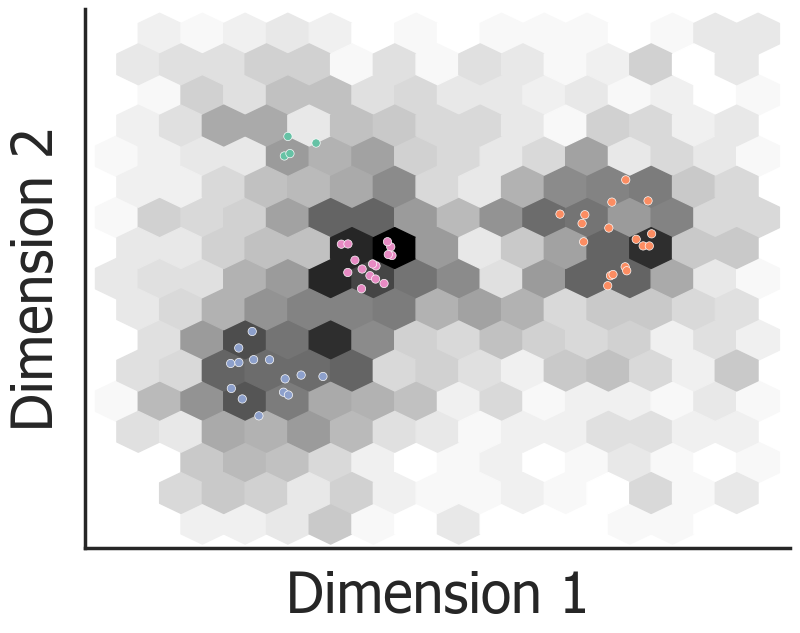

In [23]:
fig, ax = plt.subplots(1, 1, figsize=plots.stdfigsize(1,1))
ax.hexbin(tmp.loc[:,'x3'], tmp.loc[:,'x4'], cmap='gray_r', zorder=1, gridsize=15)
ax.set_xlabel('Dimension 1', fontsize=40)
ax.set_ylabel('Dimension 2', fontsize=40)
ax.set_xticks([])
ax.set_yticks([])
sns.scatterplot(data=cc, x='x3', y='x4', hue=km.labels_, zorder=2, legend=False, palette=['#66c2a5','#fc8d62','#e78ac3','#8da0cb'], ax=ax)

In [24]:
gm = GaussianMixture(
    n_components=4, covariance_type='spherical', means_init=km.cluster_centers_, fix_means=False, random_state=9
).fit(
    tmp.loc[tmp.y_true!=-1, ['x1','x2','x3','x4']].values
)

Text(0, 0.5, 'Dimension 2')

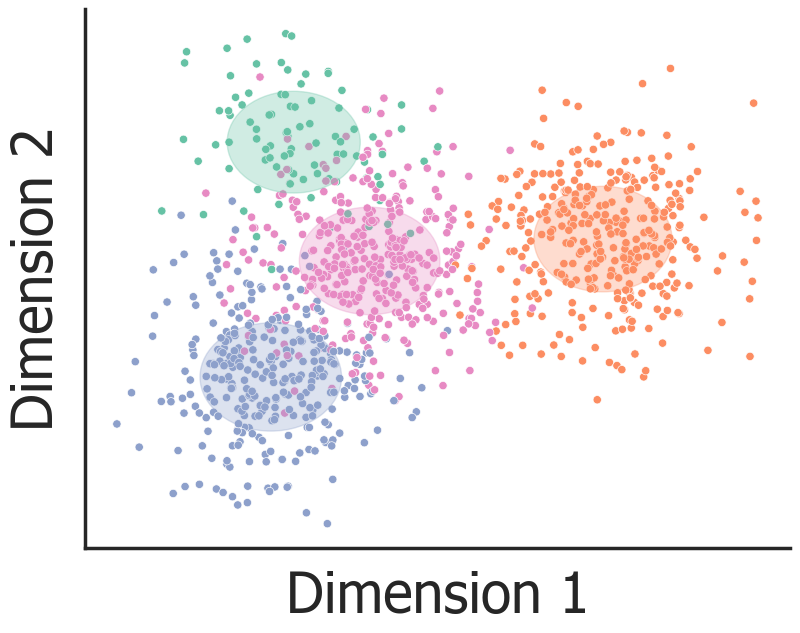

In [25]:
fig, ax = plt.subplots(1,1, figsize=plots.stdfigsize(1,1))

# f = gm.score_samples(tmp[['x1','x2','x3','x4']])>=np.quantile(gm.score_samples(tmp[['x1','x2','x3','x4']]), 1/3)
sns.scatterplot(data=tmp[tmp.y_true!=-1], x='x3', y='x4', hue='y_true', legend=False, palette=['#66c2a5','#fc8d62','#8da0cb','#e78ac3'], ax=ax)
# sns.scatterplot(data=tmp[~f], x='x3', y='x4', legend=False, color='0.8', ax=ax)
for j, (mean, cov) in enumerate(zip(gm.means_, gm.covariances_)):
    # v, w = np.linalg.eigh(cov)
    # angle = np.arctan2(w[0][3], w[0][2])
    # angle = 180. * angle / np.pi  # convert to degrees
    # v = 2. * np.sqrt(2.) * np.sqrt(v)
    v, w = np.linalg.eigh(cov*np.eye(4))
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    v = 2.0 * np.sqrt(v)

    ell = mpl.patches.Ellipse(mean[2:], v[2], v[3], angle=180. + angle, color=['#66c2a5','#fc8d62','#e78ac3','#8da0cb'][j])
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(.3)
    ax.add_artist(ell)


ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Dimension 1', fontsize=40)
ax.set_ylabel('Dimension 2', fontsize=40)

In [26]:
gm = GaussianMixture(
    n_components=4, covariance_type='full', means_init=km.cluster_centers_, fix_means=True, random_state=9
).fit(
    tmp.loc[:, ['x1','x2','x3','x4']].values
)

Text(0, 0.5, 'Dimension 2')

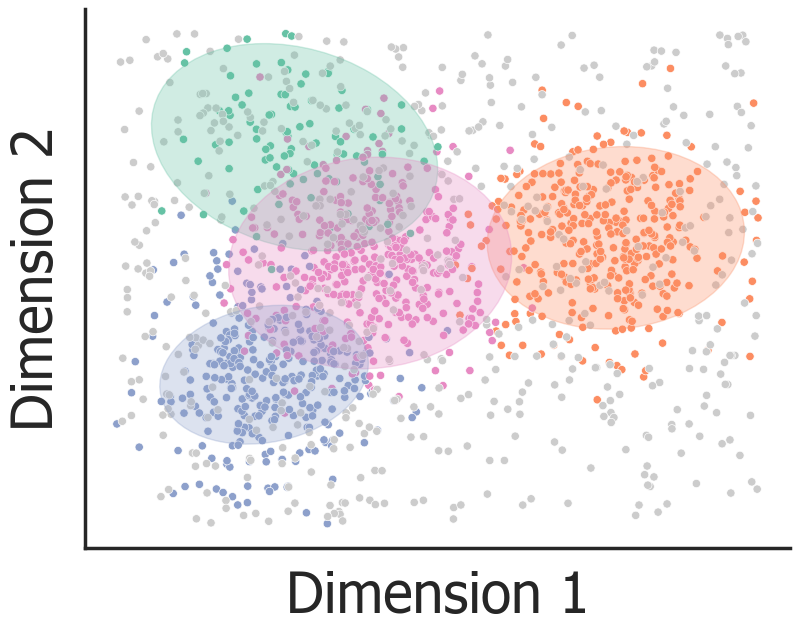

In [27]:
fig, ax = plt.subplots(1,1, figsize=plots.stdfigsize(1,1))

# f = gm.score_samples(tmp[['x1','x2','x3','x4']])>=np.quantile(gm.score_samples(tmp[['x1','x2','x3','x4']]), 1/3)
sns.scatterplot(data=tmp, x='x3', y='x4', hue='y_true', legend=False, palette=['0.8', '#66c2a5','#fc8d62','#8da0cb','#e78ac3'], ax=ax)
# sns.scatterplot(data=tmp[~f], x='x3', y='x4', legend=False, color='0.8', ax=ax)
for j, (mean, cov) in enumerate(zip(gm.means_, gm.covariances_)):
    v, w = np.linalg.eigh(cov)
    # angle = np.arctan2(w[0][3], w[0][2])
    # angle = 180. * angle / np.pi  # convert to degrees
    # v = 2. * np.sqrt(2.) * np.sqrt(v)
    # v, w = np.linalg.eigh(cov*np.eye(4))
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    v = 2.0 * np.sqrt(v)

    ell = mpl.patches.Ellipse(mean[2:], v[2], v[3], angle=180. + angle, color=['#66c2a5','#fc8d62','#e78ac3','#8da0cb'][j])
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(.3)
    ax.add_artist(ell)


ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Dimension 1', fontsize=40)
ax.set_ylabel('Dimension 2', fontsize=40)

## new noise

In [28]:
# %%time
# np.random.seed(9)

# n_smp = 20
# n_feats = [4,10]
# n_classes = [2,4,8]
# noise_ratios = [0.1, 0.5]
# rs = np.random.randint(100, size=n_smp)

# X = pd.DataFrame()
# centers_list = []
# cluster_std_list = []
# scalers_list = []

# for i in range(n_smp):
#     for n_feat in n_feats:
#         for n_class in n_classes:
#             for noise_ratio in noise_ratios:
#                 cluster_sizes = np.random.choice(range(50, 500), size=n_class, replace=False)
#                 cluster_std = np.random.uniform(1, 3, )
#                 xi,yi,ci = make_blobs(n_samples=cluster_sizes, n_features=n_feat, cluster_std=cluster_std, random_state=rs[i], return_centers=True)
#                 scaler = MinMaxScaler()
#                 xi = scaler.fit_transform(xi)
#                 ui = np.random.uniform(low=0, high=1, size=(int(sum(cluster_sizes)*noise_ratio), n_feat))
#                 xi = np.concatenate((xi,ui))
#                 yi = np.concatenate((yi, np.repeat(-1, int(sum(cluster_sizes)*noise_ratio))))
#                 xi = pd.DataFrame(xi, columns=[f'x{j}' for j in np.arange(1,n_feat+1)])
#                 xi = xi.assign(smp=i)
#                 xi = xi.assign(y_true=yi)
#                 xi = xi.assign(n_class=n_class)
#                 xi = xi.assign(n_feat=n_feat)
#                 xi = xi.assign(noise_ratio=noise_ratio)
#                 xi = xi.assign(cluster_std=cluster_std)
#                 X = pd.concat([X, xi], ignore_index=True)

#                 if n_feat == 4 and n_class == 4 and noise_ratio == 0.5 and i == 19:
#                     centers_list.append(ci)
#                     cluster_std_list.append(cluster_std)
#                     scalers_list.append(scaler)
                # break

In [29]:
# X.to_csv('../data/calculated/dp/synthetic/simulated_data.csv', index=False)
X = pd.read_csv('../data/calculated/dp/synthetic/simulated_data.csv')

In [30]:
tmp = X[(X['n_class']==4) & (X['n_feat']==4) & (X['noise_ratio']==0.5) & (X['smp']==19)]

<Axes: xlabel='x3', ylabel='x4'>

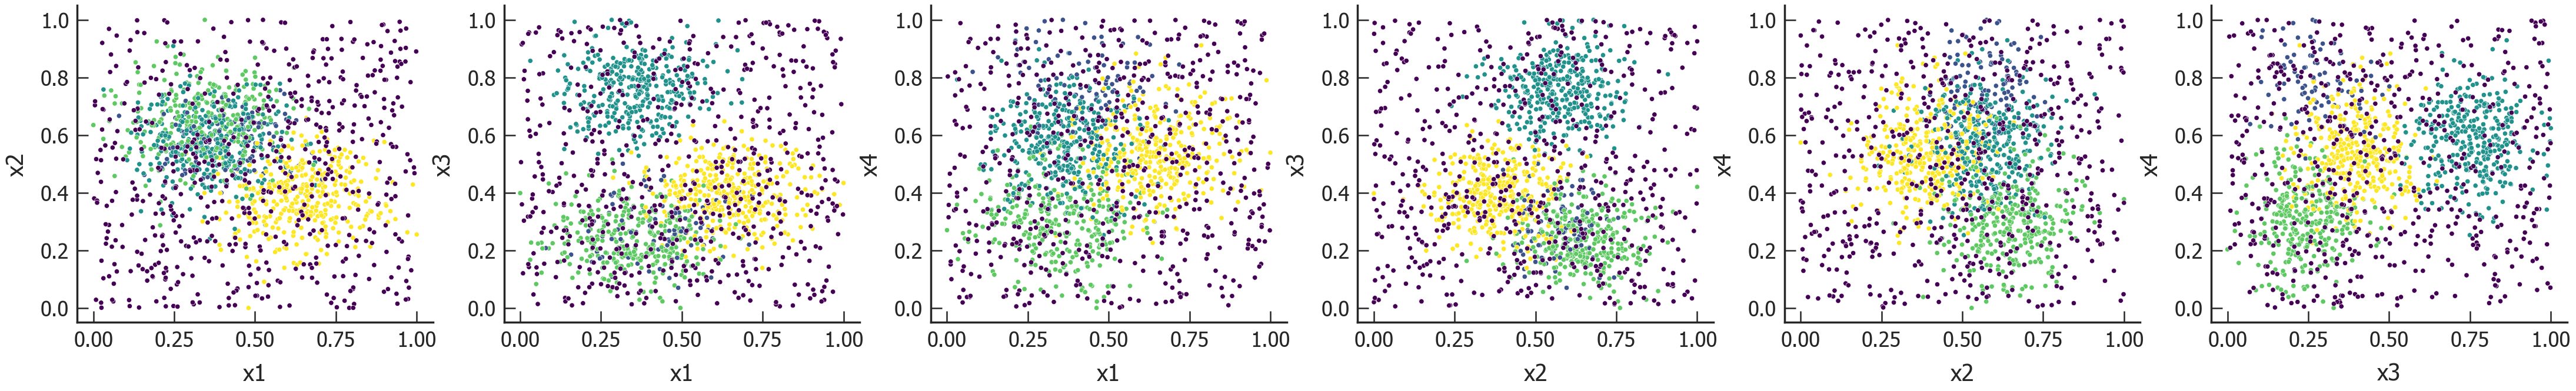

In [31]:
fig, axs = plt.subplots(1,6, figsize=plots.stdfigsize(1,6))

sns.scatterplot(data=tmp, x='x1', y='x2', hue='y_true', ax=axs[0], legend=False, palette='viridis')
sns.scatterplot(data=tmp, x='x1', y='x3', hue='y_true', ax=axs[1], legend=False, palette='viridis')
sns.scatterplot(data=tmp, x='x1', y='x4', hue='y_true', ax=axs[2], legend=False, palette='viridis')
sns.scatterplot(data=tmp, x='x2', y='x3', hue='y_true', ax=axs[3], legend=False, palette='viridis')
sns.scatterplot(data=tmp, x='x2', y='x4', hue='y_true', ax=axs[4], legend=False, palette='viridis')
sns.scatterplot(data=tmp, x='x3', y='x4', hue='y_true', ax=axs[5], legend=False, palette='viridis')

# benchmark

In [32]:
bench = pd.read_csv('../data/calculated/dp/synthetic/synthetic_bench.csv')

In [33]:
aris = bench.groupby(['smp', 'n_feat', 'n_class', 'noise_ratio']).apply(
    lambda x: adjusted_rand_score(x.y_true, x.edp_pred), include_groups=False
).to_frame('edp_ari').reset_index()

In [34]:
aris = aris.merge(bench.groupby(['smp', 'n_feat', 'n_class', 'noise_ratio']).apply(
    lambda x: adjusted_rand_score(x.y_true, x.km_mcla), include_groups=False
).to_frame('kms_ari').reset_index())

In [35]:
aris = aris.merge(bench.groupby(['smp', 'n_feat', 'n_class', 'noise_ratio']).apply(
    lambda x: adjusted_rand_score(x.y_true, x.agg_mcla), include_groups=False
).to_frame('agg_ari').reset_index())

In [36]:
tmp = aris.melt(id_vars=['smp', 'n_feat', 'n_class', 'noise_ratio'], value_vars=['edp_ari', 'kms_ari', 'agg_ari'], value_name='ari', var_name='method')

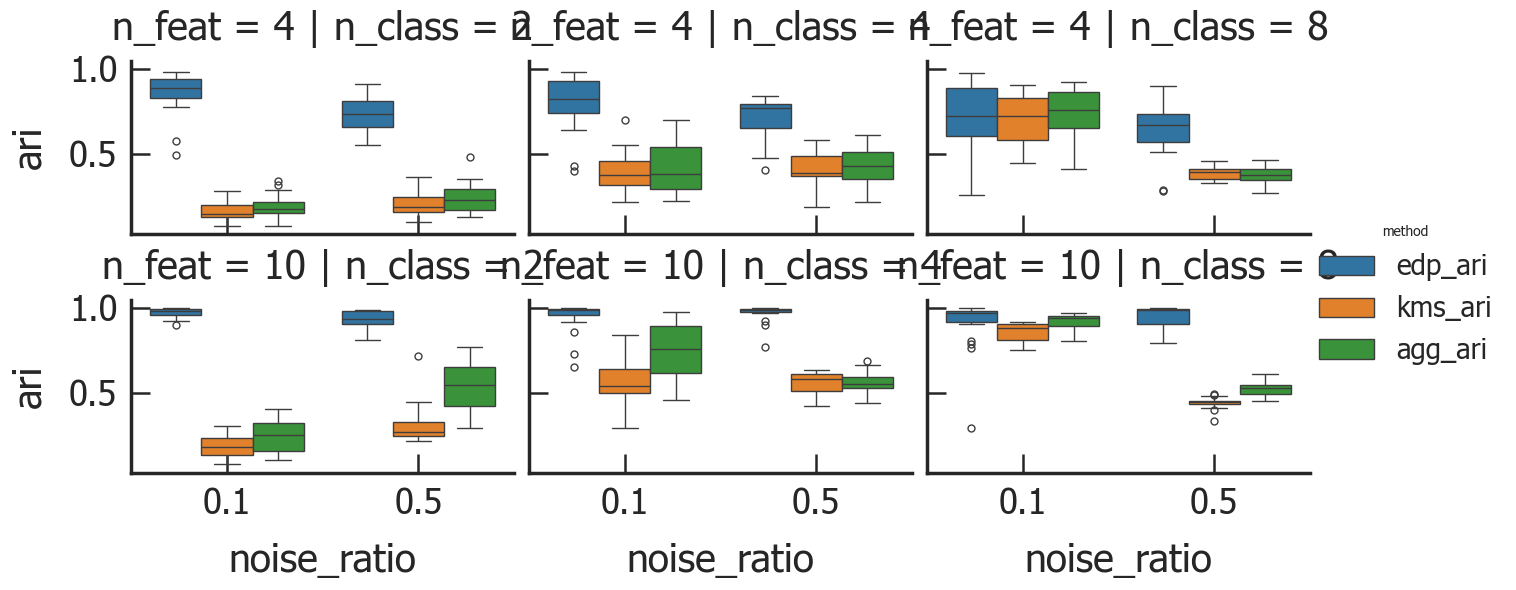

In [37]:
sns.catplot(data=tmp, x='noise_ratio', y='ari', col='n_class', row='n_feat', hue='method', kind='box', aspect=1.5, height=3)

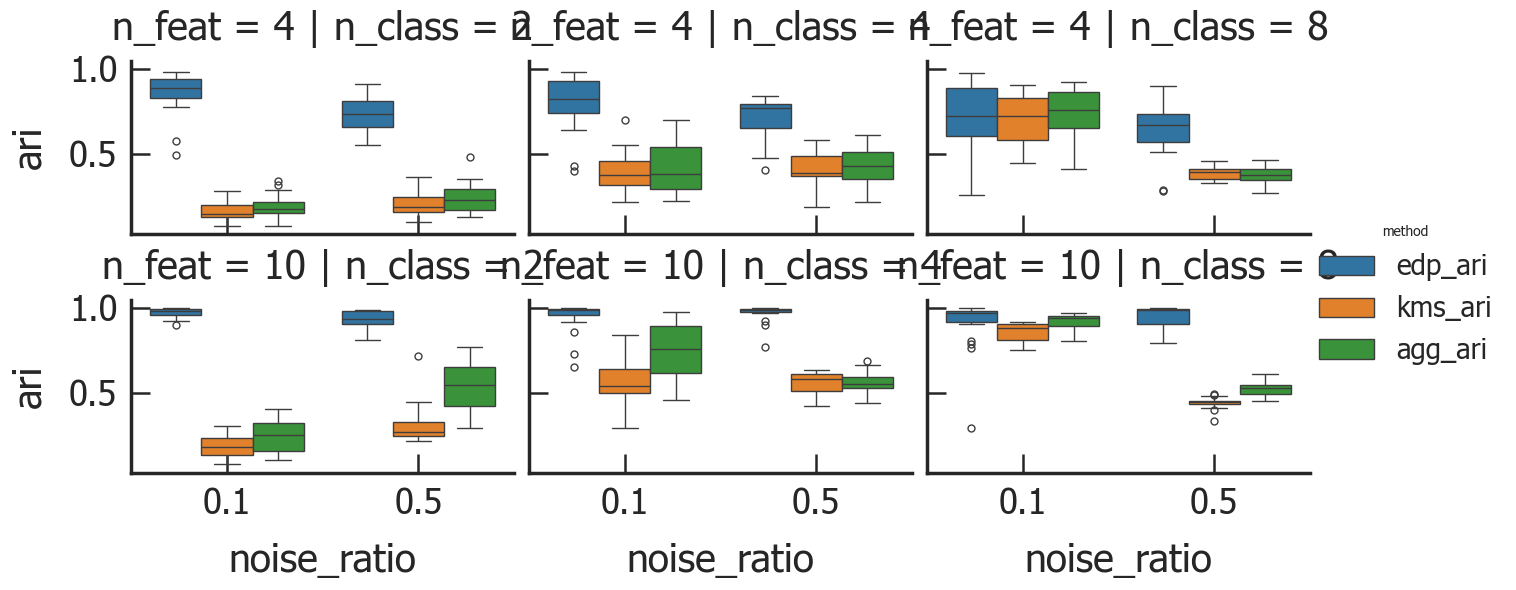

In [38]:
sns.catplot(data=tmp, x='noise_ratio', y='ari', col='n_class', row='n_feat', hue='method', kind='box', aspect=1.5, height=3)

In [39]:
tmp = X[(X['n_class']==8) & (X['n_feat']==4) & (X['noise_ratio']==0.1) & (X['smp']==6)]

<Axes: xlabel='x3', ylabel='x4'>

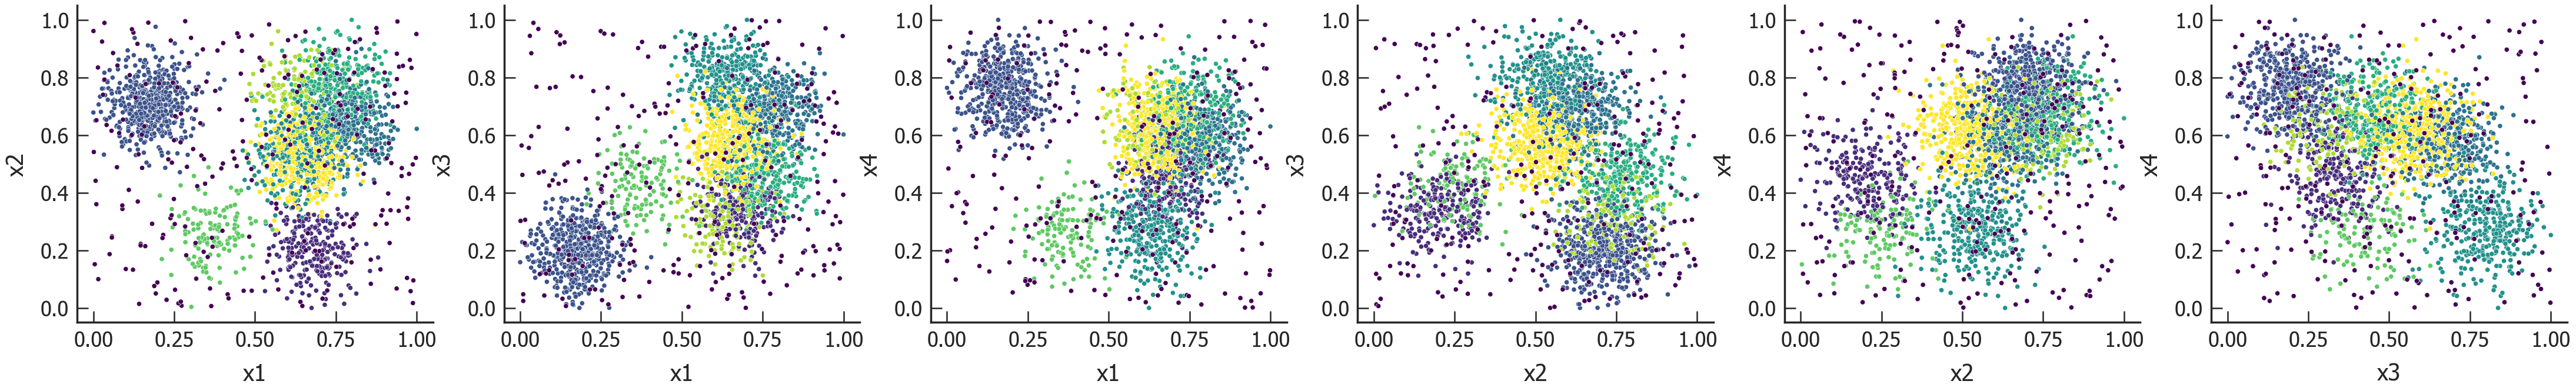

In [40]:
fig, axs = plt.subplots(1,6, figsize=plots.stdfigsize(1,6))

sns.scatterplot(data=tmp, x='x1', y='x2', hue='y_true', ax=axs[0], legend=False, palette='viridis')
sns.scatterplot(data=tmp, x='x1', y='x3', hue='y_true', ax=axs[1], legend=False, palette='viridis')
sns.scatterplot(data=tmp, x='x1', y='x4', hue='y_true', ax=axs[2], legend=False, palette='viridis')
sns.scatterplot(data=tmp, x='x2', y='x3', hue='y_true', ax=axs[3], legend=False, palette='viridis')
sns.scatterplot(data=tmp, x='x2', y='x4', hue='y_true', ax=axs[4], legend=False, palette='viridis')
sns.scatterplot(data=tmp, x='x3', y='x4', hue='y_true', ax=axs[5], legend=False, palette='viridis')

In [41]:
tmp = tmp.assign(
    rho = dps.loc[(dps['n_class']==8) & (dps['n_feat']==4) & (dps['noise_ratio']==0.1) & (dps['smp']==6) & (dps['boot']=='all'), 'rho'].values, 
    delta = dps.loc[(dps['n_class']==8) & (dps['n_feat']==4) & (dps['noise_ratio']==0.1) & (dps['smp']==6) & (dps['boot']=='all'), 'delta'].values, 
    rd = dps.loc[(dps['n_class']==8) & (dps['n_feat']==4) & (dps['noise_ratio']==0.1) & (dps['smp']==6) & (dps['boot']=='all'), 'rd'].values,
)


Text(0, 0.5, 'Inter-peak distance')

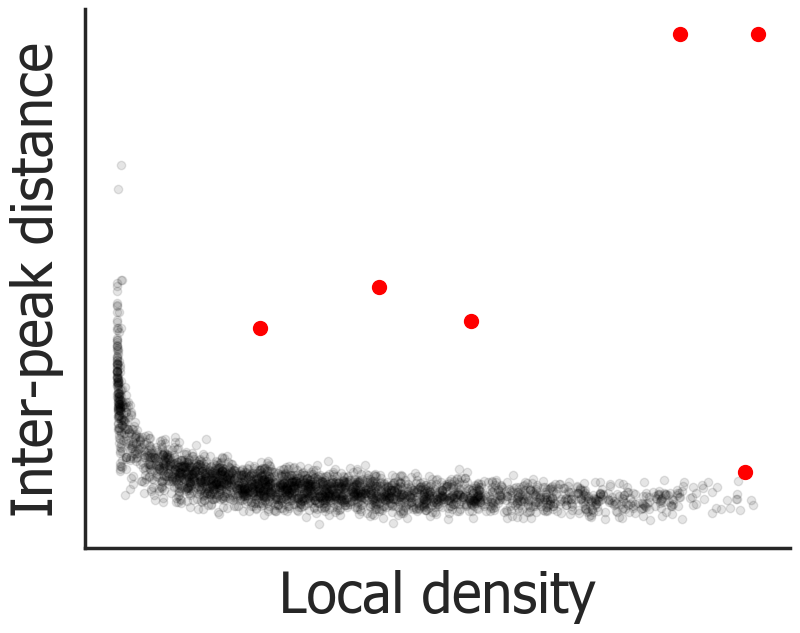

In [42]:
fig, ax = plt.subplots(1, 1, figsize=plots.stdfigsize(1,1))
ax.scatter(tmp.rho, tmp.delta, color='black', alpha=.1)
ax.scatter(tmp.sort_values('rd', ascending=False).rho[:6], tmp.sort_values('rd', ascending=False).delta[:6], s=100, color='red')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Local density', fontsize=40)
ax.set_ylabel('Inter-peak distance', fontsize=40)

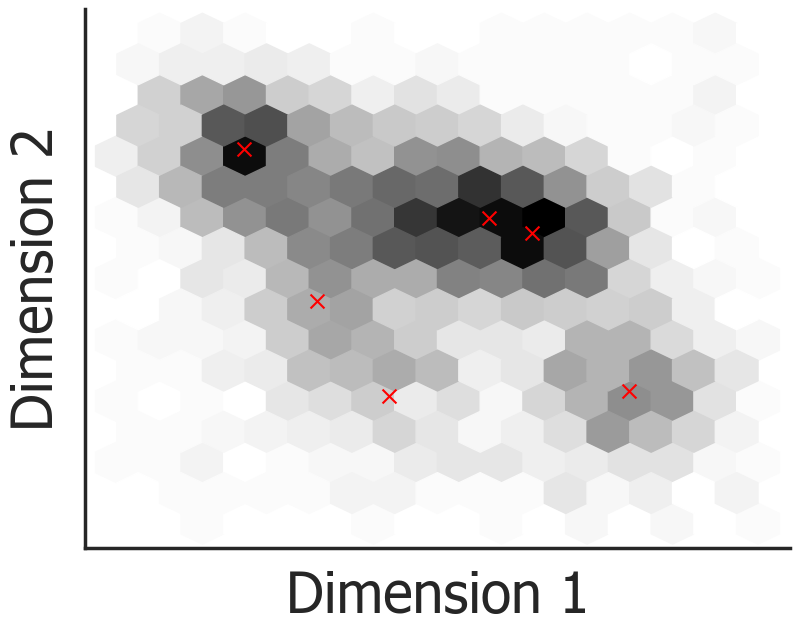

In [43]:
fig, ax = plt.subplots(1, 1, figsize=plots.stdfigsize(1,1))
ax.hexbin(tmp.loc[:,'x3'], tmp.loc[:,'x4'], cmap='gray_r', zorder=1, gridsize=15)
ax.set_xlabel('Dimension 1', fontsize=40)
ax.set_ylabel('Dimension 2', fontsize=40)
ax.set_xticks([])
ax.set_yticks([])
ax.scatter(tmp.sort_values('rd', ascending=False).x3[:6],tmp.sort_values('rd', ascending=False).x4[:6], marker='x',color="red", zorder=2, s=100)

Text(0.02, 0.5, 'Silhouette score')

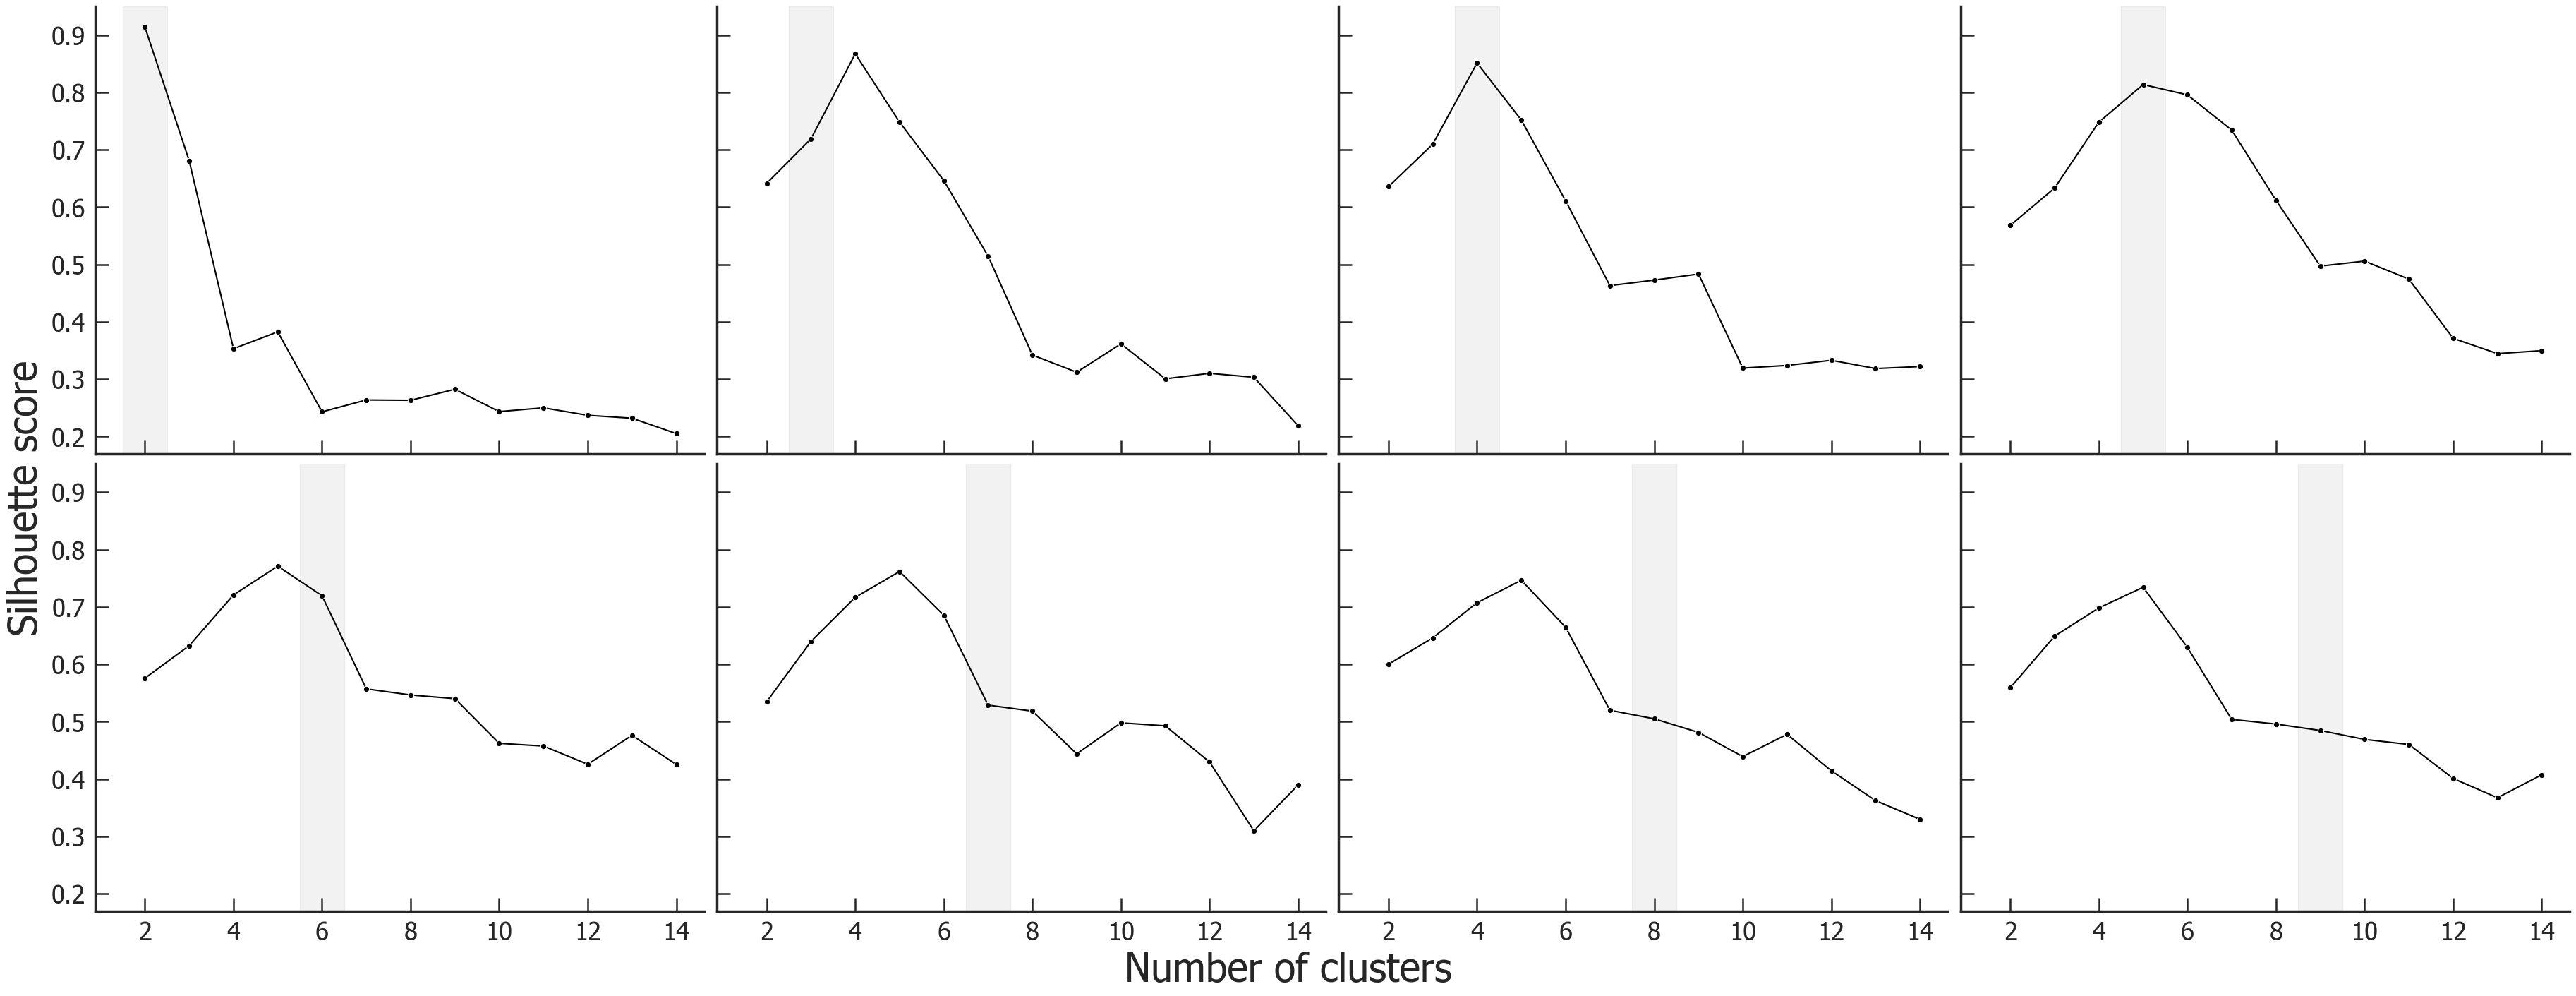

In [44]:
grps = sls[(sls['n_class']==8) & (sls['n_feat']==4) & (sls['noise_ratio']==0.1) & (sls['smp']==6)].groupby('n_cmp_assume')

nc = 4
nr = 2
fig, axs = plt.subplots(nr, nc, figsize=plots.stdfigsize(nx=nc, ny=nr), constrained_layout=True, sharex=True, sharey=True)
for n_cmp_assume, grp in grps:
    if n_cmp_assume >= 10:
        break
    ax = axs.flatten()[n_cmp_assume-2]

    sns.lineplot(data=grp, x='n_cmp', y = 'sl', ax=ax, color='black', marker='o')
    ax.axvspan(n_cmp_assume-0.5, n_cmp_assume+0.5, color='gray', alpha=0.1)
    ax.set_xlabel('')
    ax.set_ylabel('')
fig.supxlabel('Number of clusters', ha='center', fontsize=40)
fig.supylabel('Silhouette score', va='center', fontsize=40)

In [54]:
bench = pd.read_csv('../data/calculated/dp/synthetic/synthetic_bench.csv')

In [55]:
aris = bench.groupby(['smp', 'n_feat', 'n_class', 'noise_ratio']).apply(
    lambda x: adjusted_rand_score(x.y_true, x.edp_pred), include_groups=False
).to_frame('edp_ari').reset_index()

In [56]:
aris = aris.merge(bench.groupby(['smp', 'n_feat', 'n_class', 'noise_ratio']).apply(
    lambda x: adjusted_rand_score(x.y_true, x.km_mcla), include_groups=False
).to_frame('kms_ari').reset_index())

In [57]:
aris = aris.merge(bench.groupby(['smp', 'n_feat', 'n_class', 'noise_ratio']).apply(
    lambda x: adjusted_rand_score(x.y_true, x.agg_mcla), include_groups=False
).to_frame('agg_ari').reset_index())

In [58]:
tmp = aris.melt(id_vars=['smp', 'n_feat', 'n_class', 'noise_ratio'], value_vars=['edp_ari', 'kms_ari', 'agg_ari'], value_name='ari', var_name='method')

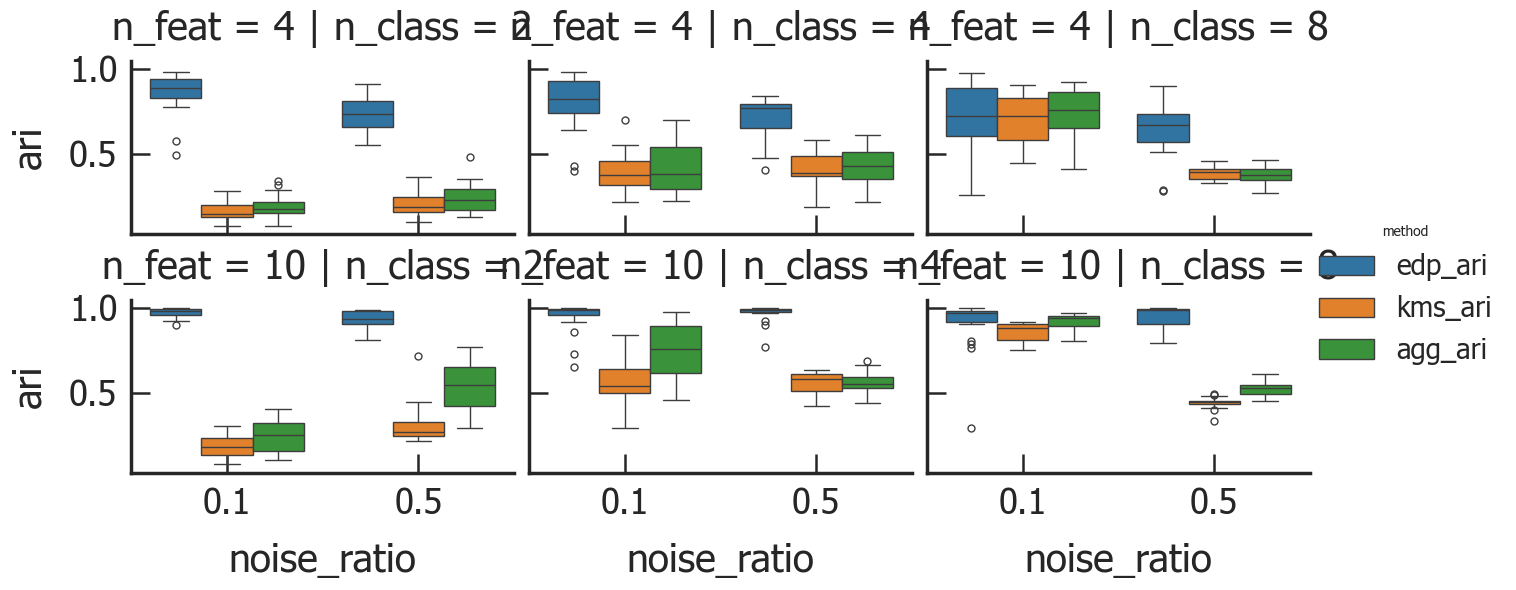

In [59]:
sns.catplot(data=tmp, x='noise_ratio', y='ari', col='n_class', row='n_feat', hue='method', kind='box', aspect=1.5, height=3)

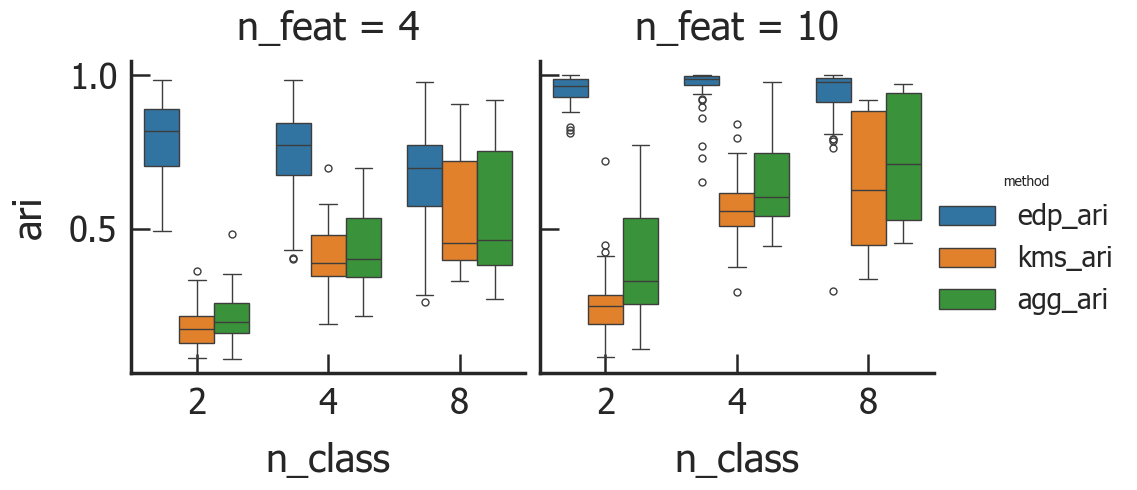

In [60]:
sns.catplot(data=tmp, x='n_class', y='ari', hue='method', col='n_feat', kind='box')